Model Accuracy: 79.91%


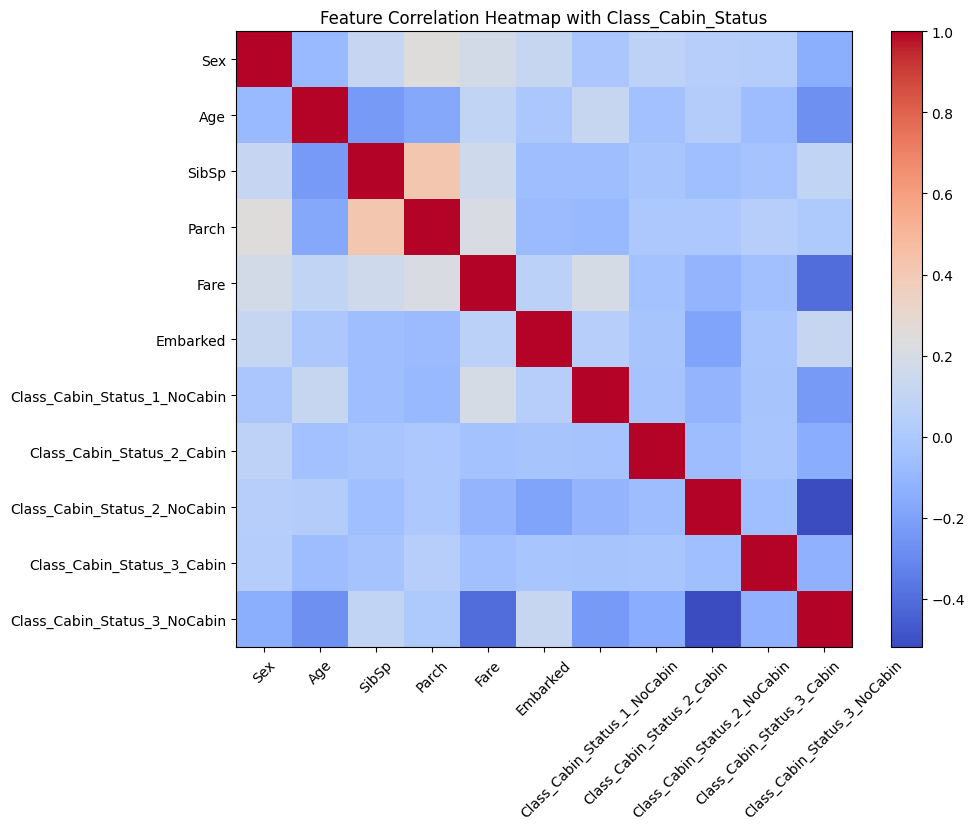

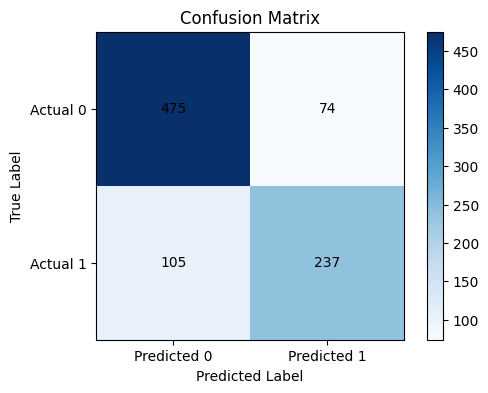

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/arnav/Downloads/titanic.csv'
titanic_data = pd.read_csv(file_path)

# Data preprocessing
# Create a new feature 'Class_Cabin_Status' based on Pclass and cabin availability
titanic_data['Class_Cabin_Status'] = titanic_data.apply(
    lambda row: f"{row['Pclass']}_Cabin" if pd.notna(row['Cabin']) else f"{row['Pclass']}_NoCabin",
    axis=1
)

# Drop unnecessary columns
titanic_data = titanic_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Pclass'])

# Handle missing values (using median for numeric, mode for categorical)
def handle_missing_values(column):
    if pd.api.types.is_numeric_dtype(column):
        return column.fillna(column.median())
    else:
        return column.fillna(column.mode()[0])

for col in titanic_data.columns:
    titanic_data.loc[:, col] = handle_missing_values(titanic_data[col])

# Encode categorical variables
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})
titanic_data['Embarked'] = titanic_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Convert the new Class_Cabin_Status feature to numerical format using one-hot encoding
titanic_data = pd.get_dummies(titanic_data, columns=['Class_Cabin_Status'], drop_first=True)

# Separate features and target
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived'].values

# Ensure all data types are numeric (after handling non-numeric columns)
X = X.astype(float)  # Convert to float type

# Check for NaN values in X (shouldn't be any, but ensures cleanliness)
X = X.fillna(0)

# Standardize the feature matrix
X_mean = np.mean(X, axis=0)

# Calculate standard deviation, handling potential single-feature case
if X.shape[1] == 1:  # Check if there's only one feature
    X_std = np.std(X, axis=0)  # Calculate std for single feature
    if X_std == 0:
        X_std = 1  # Avoid division by zero
else:
    X_std = np.std(X, axis=0)  # Use np.std for multiple features

# Standardization
X = (X - X_mean) / X_std

# Logistic Regression Class
class LogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Train the model using gradient descent."""
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """Predict binary class labels."""
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]

    def accuracy(self, y_true, y_pred):
        """Calculate the accuracy of the model."""
        return np.mean(y_true == y_pred) * 100

# Initialize and train the logistic regression model
log_reg = LogisticRegression(learning_rate=0.01, iterations=1000)
log_reg.fit(X, y)

# Make predictions and calculate accuracy
predictions = log_reg.predict(X)
accuracy = log_reg.accuracy(y, predictions)
print(f"Model Accuracy: {accuracy:.2f}%")

# Heatmap of feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = pd.DataFrame(X, columns=titanic_data.drop(columns="Survived").columns).corr()
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), titanic_data.drop(columns="Survived").columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), titanic_data.drop(columns="Survived").columns)
plt.title("Feature Correlation Heatmap with Class_Cabin_Status")
plt.show()

# Confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix based on predictions and true values."""
    confusion_matrix = np.zeros((2, 2))
    for true, pred in zip(y_true, y_pred):
        confusion_matrix[true][pred] += 1

    plt.figure(figsize=(6, 4))
    plt.title("Confusion Matrix")
    plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['Actual 0', 'Actual 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, int(confusion_matrix[i, j]), ha='center', va='center', color='black')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y, predictions)